# 12주 2강: Hypothesis Testings

Allen B. Downey의 http://thinkstats2.com 코드를 참조했습니다.

이번 강의는 가설의 검정에 대해서 배우겠습니다.

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import scipy.stats
import pandas as pd

## Hypothesis testing
p-value를 statistic이 아닌 직접 구하는 것 부터 해 봅시다.

In [2]:
class HypothesisTest(object):
    # 공통적으로 많이 사용할 Method들에 대한 HyothesisTest class를 만들어둡니다

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)
        self.test_stats = None
        self.test_cdf = None        

    def PValue(self, iters=1000):
        # p-value는 가설에 대해서 현재 관측한 data나 worse data가 나올 확률입니다.
        # simulation을 통해서 p-value를 구해봅시다.
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]
        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()
        
    def MaxTestStat(self):
        return max(self.test_stats)

In [3]:
class CoinTest(HypothesisTest): 
    # Hypothesis Test class를 상속받
    # python의 상속에 대해 잊으셧다면 2주차 강의를 다시 참조해주세요
    # 2주차 예제코드를 보셔도 됩니다 (WEEK02-01_PythonBasics.ipynb)

    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat

    def RunModel(self):
        # 이 Model은 unbaised coin이므로 전체 샘플의 1/2씩 나오는 경우입니다.
        from collections import Counter
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = Counter(sample)
        # Counter로 histogram을 만들어줍시다
        data = hist['H'], hist['T']
        return data

In [4]:
ct = CoinTest((140, 110))
pvalue = ct.PValue(iters=1000)
print(pvalue)
# p-value는 0.07 내외가 나옵니다. 
# 즉, 확률이 같다는 가정 하에서는 나오기 힘든 sample이라는 것이지요.

0.054


In [5]:
# chi-squared 검정을 해 보겠습니다.
# expectation을 넣지 않으면 모두 같은 확률로 가정합니다.
#coin_expectation = [125, 125]
coin_observation = [140, 110]
scipy.stats.chisquare(coin_observation)
#scipy.stats.chisquare(coin_observation), coin_expectation)

Power_divergenceResult(statistic=3.6, pvalue=0.05777957112359715)

## Permutation test
두 그룹의 mean이 같은지 다른지 평가하는 방법 중 하나는 permuation test입니다. 두 그룹의 평균이 같다고 가정하고, 두 그룹의 데이터를 서로 섞어도 같은 결과가 나오는지 보는 방법이지요!

In [6]:
class DiffMeansPermute(HypothesisTest):
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

    def values2cdf(self, values):
        sorted_values = sorted(values)
        total = len(values)
        x = []
        y = []
        for i, value in enumerate(sorted_values):
            x.append(value)
            y.append(i/total)
        return x, y
    
    def PlotCdf(self, label=None):
        self.test_cdf = self.values2cdf(self.test_stats)
        def VertLine(x):
            plt.plot([x, x], [0, 1], color='0.8')
        VertLine(self.actual)
        plt.plot(self.test_cdf[0], self.test_cdf[1])

In [7]:
# 다시 한 번 첫번째 아이의 임신기간 문제로 돌아가 봅시다. 
# Effect size로 평가해 본 적이 있지만, 실제로 두 집단의 평균이 같을까요?
preg = pd.read_csv("./2002FemPreg.tsv", sep = "\t")
live = preg[preg.outcome == 1]
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]
data = firsts.prglngth.values, others.prglngth.values

0.163


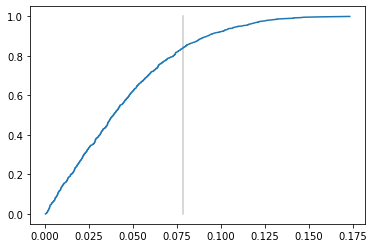

In [8]:
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
print(pvalue)
ht.PlotCdf()
# p-value는 0.17정도가 나옵니다. 
# 즉, 이 결과는 Statistically significant 하지 않네요.

In [9]:
# t-test 검정을 해 보겠습니다.
# 두 개의 independent sample에 대해서는 scipy.stats.ttest_ind를 쓰면 됩니다.
scipy.stats.ttest_ind(data[0], data[1], equal_var=True)

Ttest_indResult(statistic=1.3802152088125652, pvalue=0.16755412639415004)

In [10]:
# 이번에는 one-sided test를 해 봅시다. 
# 첫째의 임신 기간 평균이 둘째 이후의 임신 기간보다 "길다"는 가설을 설정합시다
# H0: Mu_A >= Mu_B
class DiffMeansOneSided(DiffMeansPermute):
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

In [11]:
ht = DiffMeansOneSided(data)
pvalue = ht.PValue()
pvalue
# Statistically significant 하지 않네요.

0.072

In [12]:
# H0: Mu_A >= Mu_B 를 t-test를 하려면 어떻게 해야할까요?
t1 = scipy.stats.ttest_ind(data[0], data[1], equal_var=True)
t1
# t 분포는 0을 중심으로 대칭입니다. 
# 그러므로 t값이 0보다 큰지 확인하고, p/2가 alpha보다 큰지를 확인하면 됩니다.
# t 값이 0보다 크지만, p/2가 0.084 정도로 귀무가설을 기각할 정도는 아니네요
# statistically significant하지 않습니다.

Ttest_indResult(statistic=1.3802152088125652, pvalue=0.16755412639415004)

In [13]:
# Standard deviation은 차이가 있을까요?
class DiffStdPermute(DiffMeansPermute):
    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

In [14]:
ht = DiffStdPermute(data)
pvalue = ht.PValue()
pvalue
# Statistically significant 하지 않네요.

0.073

## Testing correlation
관측된 correlation이 실제로 statistically significant 한지 보려면, 둘 중 한 변수의 순서를 랜덤하게 바꾸는 permutation test를 통해서 p-value를 구할 수 있습니다

In [15]:
class CorrelationPermute(HypothesisTest):
    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(scipy.stats.pearsonr(xs, ys)[0])
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        # inlplace이기 떄문에 np.shuffle을 쓰셔도 됩니다.
        return xs, ys

In [16]:
cleaned = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data = cleaned.agepreg.values, cleaned.totalwgt_lb.values
ht = CorrelationPermute(data)
pvalue = ht.PValue()
print(pvalue)
# 사실 p-value가 0은 아닙니다. iteration이 1000번이므로, p-value가 1/1000보다
# 작다는 사실만 알려주지요.

0.0


In [17]:
# scipy의 pearsonr은 p-value를 같이 알려줍니다.
print(scipy.stats.pearsonr(data[0], data[1]))

(0.0688339703541089, 5.7229471072230746e-11)


In [18]:
# 혹은 실제 correlation이 simulation의 최대값과 얼마나 차이나는지 
# 비교할 수도 있습니다
ht.actual, ht.MaxTestStat()

(0.0688339703541089, 0.03843154646915016)

## Testing proportions
6면체 주사위에 대해서 각 면이 나오는 비율에 대한 statistical test를 해 봅시다. 정상 주사위는 당연히 1/6확률로 모든 면이 나와야겠죠.

In [19]:
class DiceTest(HypothesisTest):
    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat
  
    def RunModel(self):
        from collections import Counter       
        n = sum(self.data)
        values = [1, 2, 3, 4, 5, 6]
        rolls = np.random.choice(values, n, replace=True)        
        hist = Counter(rolls)
        freqs = np.array([hist.setdefault(x, 0) for x in values])
        # 그냥 values 를 쓰면 가끔 한 숫자가 한번도 안뽑히는 에러가 납니다.
        # setdefault는 값이 없으면 0을 리턴해줍니다.
        return freqs

In [20]:
data = [8, 9, 19, 5, 8, 11]
dt = DiceTest(data)
pvalue = dt.PValue(iters=10000)
print(pvalue)
# 역시나 statistically significant 하지 않습니다. 

0.1296


In [21]:
# chi-suqred test를 해 봅시다.
# 먼저 직접 구현을 해 봅시다.
class DiceChiTest(DiceTest):
    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat

In [22]:
dt = DiceChiTest(data)
pvalue = dt.PValue(iters=10000)
print(pvalue)

0.0428


In [23]:
# scipy.stats의 chi-square test를 써 봅시다.
print(scipy.stats.chisquare(data))

Power_divergenceResult(statistic=11.6, pvalue=0.040699388504049985)


In [24]:
# chi-square test에서는 statistiaclly significant한 p-value가 나옵니다. 
# 두가지가 왜 다르게 나올까요? 고민해보세요.

## Chi-squared test of pregnancy length

In [25]:
# 위의 방법을 활용해서 임신 기간에 대해서 chi-squared test를 해 봅시다.
# 첫째 아이와 그 이후 아이들의 임신 기간 "분포"가 얼마나 다른지 보겠습니다.
# 두 경우를 모두 포괄한 것이 모델 분포라고 가정하고, 
# 첫째 아이와 둘째 이후 아이가 얼마나 이 분포에서 달라지는지 봅시다.
class PregLengthTest(HypothesisTest):
    def MakeModel(self):
        from collections import Counter       
        firsts, others = self.data
        self.n = len(firsts)        
        self.pool = np.hstack((firsts, others))
        hist = Counter(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array([hist.setdefault(x, 0)/len(self.pool) for x in self.values])

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        from collections import Counter
        hist = Counter(lengths)
        observed = np.array([hist.setdefault(x, 0) for x in self.values])
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

In [26]:
data = firsts.prglngth.values, others.prglngth.values
ht = PregLengthTest(data)
p_value = ht.PValue()
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())

p-value = 0.0
actual = 101.50141482893264
ts max = 29.432543767942313


In [27]:
# scipy.statst의 chisquare를 통해서도 구해봅시다

from collections import Counter
hist = Counter(firsts.prglngth.values)
observed = np.array([hist.setdefault(x, 0) for x in range(35, 44)])
print(scipy.stats.chisquare(observed, ht.expected_probs))

hist = Counter(others.prglngth.values)
observed = np.array([hist.setdefault(x, 0) for x in range(35, 44)])
print(scipy.stats.chisquare(observed, ht.expected_probs))

Power_divergenceResult(statistic=18289371.172292933, pvalue=0.0)
Power_divergenceResult(statistic=21399011.172292933, pvalue=0.0)


## power (검정력)
실제로 이 test가 얼마나 검정력이 확인하기 위한 테스트를 아래의 함수로 수행해 보겠습니다.

In [28]:
def FalseNegRate(data, num_runs=1000):
    # Resampling을 통해서 false negative가 얼마나 찾아지는지를 봅시다.
    # Type 1 Error를 찾는 것입니다. 
    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = np.random.choice(group1, len(group1), replace=True)
        sample2 = np.random.choice(group2, len(group2), replace=True)
        ht = DiffMeansPermute((sample1, sample2))
        p_value = ht.PValue(iters=101)
        if p_value > 0.05:
            count += 1

    return count / num_runs

In [29]:
neg_rate = FalseNegRate(data)
neg_rate

0.714

결과는 약 70%입니다. 이 값이 의미하는 바는 평균 임신기간의 실제 차이가 0.078주라면, 이 표본 실험은 대략 70%정도 False Negative를 찾아낸다는 것입니다. 즉, True positive를 찾아내느 경우는 단 30%에 지나지 않습니다. 이 검정은 그래서 검정력이 부족합니다 (underpowered).

## Excercieses

**Excercise:** 표본크기가 증가함에 따라, 가설검정력은 증가합니다. 반대로 표본크기가 줄어들면 검정력은 효과가 실제로 있다고 해도 작아질 것입니다. 데이터프레임에 임의로 일부 행을 선택해서, 표본 크기를 감소시켜봅시다. 그리고 표본 크기에 따라 p-value값이 어느정도 변하는지 확인해 봅시다. 

샘플링은 ```pandas.DataFrame.sample``` 을 사용하면 됩니다.

In [30]:
# solution goes here

**Exercise:** 앞에서 우리는 null hypothesis를 permutation을 통해 simulation했습니다. 이 방법은 우리의 데이터의 값들이 전체 population을 대표하는 값으로 간주하고 하는 방법입니다.

이와 다른 방법으로는 sample을 통헤서 population distribution을 추정하고, 그 distribution에서 뽑은 random sample을 통해서 p-value를 구하는 것입니다. 이 방법을 resampling이라고 합니다. 위의 ```np.random.choice(group1, len(group1), replace=True)``` 같은 형태로 말이죠.

`DiffMeansResample`라는 클래스를 `DiffMeansPermute`를 상속해서 만드시고, `RunModel`을 permuation 대신 reampling으로 만들어 보세요. 그리고 이 모델을 통해 임신기간(```prglngth```) 과 몸무게(```totalwgt_lb```)에 대한 실험을 수행해보세요. 결과가 얼마나 달라지나요?

In [31]:
# solution goes here